#### Objective

In this notebook 

#### Preliminaries - import main libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from skimage import segmentation, color
from skimage.color import rgb2gray 

from skimage.morphology import disk, square, closing, opening, erosion, dilation
from skimage.morphology import reconstruction, remove_small_objects

%matplotlib inline

In [2]:
import requests
from PIL import Image
from StringIO import StringIO

#### Import test image

In [3]:
url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebook/test1.png'
r = requests.get(url)
img = np.asarray(Image.open(StringIO(r.content)).convert('RGB'))

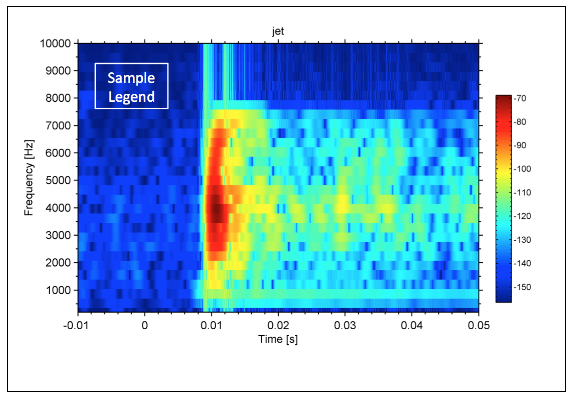

In [4]:
# plot image
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
plt.imshow(img)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

#### Find the map

We want to eliminate both possibilities of ~black and ~nearly white border

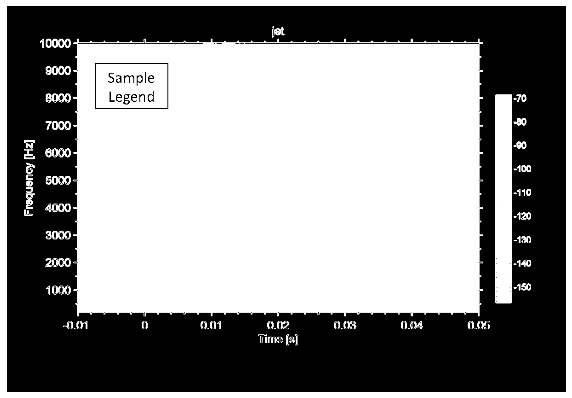

In [5]:
binary = np.logical_and(color.rgb2gray(img) > 0.02, color.rgb2gray(img) < 0.98)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Close small gaps

If present, eliminates small dar spots with closing

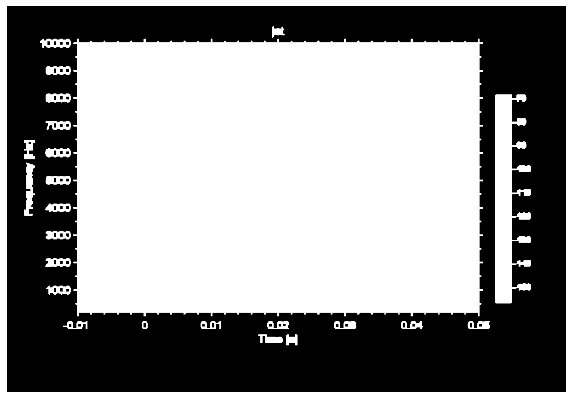

In [6]:
closed = closing(binary, square(5))  # have to make structuring element size based on image size heuristic

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(closed, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Get largest element in ghe binary image and use it as a mask for the original image

Detect largest bright element in the binary image. Making the assumption it would be the map.
This should also take care of text and other small bright elements usually removed with opening.

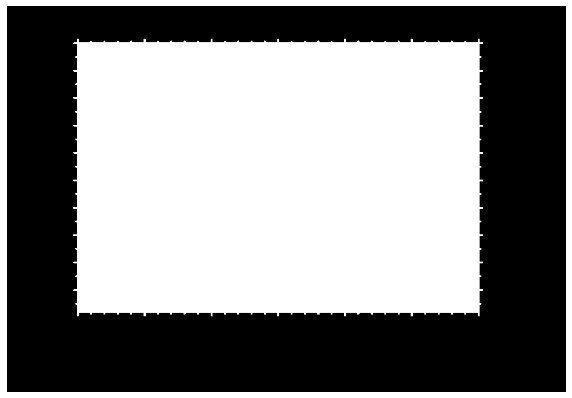

In [11]:
# label all white objects ( made up of ones)
label_objects, nb_labels = sp.ndimage.label(closed) 

# calculate every labeled object's size
sizes = np.bincount(label_objects.ravel())             

# keep only largest object
mask_sizes = sizes == max(sizes)                                
mask_sizes[0] = 0                                        
binary_cleaned = mask_sizes[label_objects]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_cleaned, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

In [23]:
# convert it to a 3D array mask to use in next cell

mask3 = np.zeros(img.shape)
mask3[:,:,0] = binary_cleaned
mask3[:,:,1] = binary_cleaned
mask3[:,:,2] = binary_cleaned

In [21]:
# use the mask to get only the map in the original image
final = np.ma.masked_where(mask3 == False, img)
final = final.filled(0)

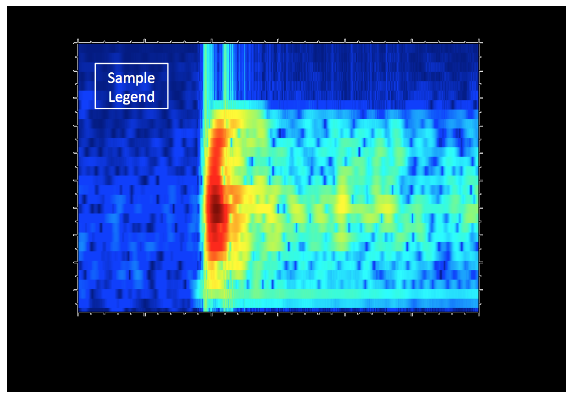

In [22]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(final)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Crop zero columns and zero rows

http://stackoverflow.com/a/14211727/1034648

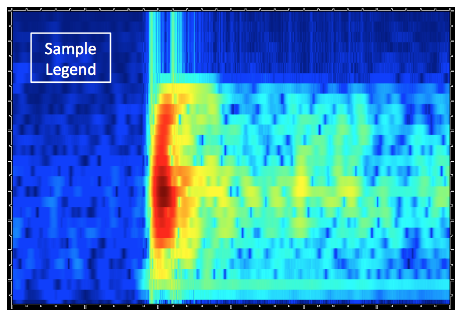

In [24]:
non_empty_columns = np.where(final.max(axis=0)>0)[0]
non_empty_rows = np.where(final.max(axis=1)>0)[0]
cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

final_crop = final[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.imshow(final_crop, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Reduce number of colours

I use here Scikit-learn segmentation using k-means clustering in Color-(x,y,z) space:
http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

In [ ]:
labels1 = segmentation.slic(img, compactness=30, n_segments=32, convert2lab = 'True') 
out1 = color.label2rgb(labels1, img, kind='avg')

print np.shape(labels1)
print np.shape(out1)

print labels1[200]

In [ ]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(out1)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()



#### Convert from RGB to Lab, get 32 unique triplets of L, a, b

In [ ]:
lab = rgb2lab(out1)

print lab.shape

I tried two methods that return the same result:

1) get H, L, combine into 2D array, sort unique rows

2) sort H, with index returned then sort L with index

In [ ]:
width, height, dump = np.shape(out2)
print  width, height, dump

In [ ]:
# method 1
# extract lightness and hue, combine them into a 2D array

# extract
from skimage.color import rgb2lab, lab2lch, lch2lab, lab2rgb
lab = rgb2lab(out2)
lch = lab2lch(lab)
        
lab = np.asarray(lab)
lch = np.asarray(lch)


# reshape
pixels_lab = np.reshape(lab, (width*height, -1))
l1, a, b = np.split(pixels_lab, 3, axis=-1)
        
pixels_lch = np.reshape(lch, (width*height, -1))
l2, c, h = np.split(pixels_lch, 3, axis=-1)
 
# flatten    
import itertools
lM = list(itertools.chain.from_iterable(l2))
hM = list(itertools.chain.from_iterable(h))

# zip together to make 2D numpy array
lhM = np.asarray(zip(hM,lM))


In [ ]:
# Sorting unique rows
# Joe Kington's answer on Stackoverflow: http://stackoverflow.com/a/16971224
def unique_rows(data):
    uniq = np.unique(data.view(data.dtype.descr * data.shape[1]))
    return uniq.view(data.dtype).reshape(-1, data.shape[1])

In [ ]:
uniqLM = unique_rows(lhM)
print np.shape(uniqLM)

In [ ]:
# method 2
# sorting both lightness and hue by hue separately

from skimage.color import rgb2lab, lab2lch, lch2lab, lab2rgb
lab = rgb2lab(out2)
lch = lab2lch(lab)
        
lab = np.asarray(lab)
lch = np.asarray(lch)


pixels_lab = np.reshape(lab, (width*height, -1))
l1, a, b = np.split(pixels_lab, 3, axis=-1)
        
pixels_lch = np.reshape(lch, (width*height, -1))
l2, c, h = np.split(pixels_lch, 3, axis=-1)
                
huniq, unidx = np.unique(h, return_index=True)
luniq = l2[unidx]
cuniq = c[unidx]

# flatten luniq, cuniq
import itertools 
luniqM = list(itertools.chain.from_iterable(luniq))
cuniqM = list(itertools.chain.from_iterable(cuniq))

In [ ]:
# compare output of two methods
lhM2 = np.asarray(zip(huniq,luniqM))
print 'method 2'
print '         H            L' 
print lhM2[:4]
print lhM2[-4:]

print 'method 1'
print '         H            L' 
print uniqLM[:4]
print uniqLM[-4:]

In [ ]:
np.shape(uniqLM)

#### Import a function to plot colored lines in the final plot using the colormap created above


From David Sanders:
https://github.com/dpsanders/matplotlib-examples/blob/master/colorline.ipynb

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

#### Make final plot of the sorted hue, H versus lightness, L, colored by L

In [ ]:
# To color by L, it has to be normalized to [0 1]
luniqM_n=(luniqM-min(luniqM))/(max(luniqM)-min(luniqM))

fig = plt.figure(figsize=(8,4))
plt.xticks(np.arange(0, 2.25*np.pi,0.25*np.pi),[0.,   45.,   90.,  135.,  180.,  225.,  270.,  315., 360.]) 
# Hue as 0-360 angle

ax1 = fig.add_subplot(111)

# ax1.scatter(huniq, luniq)
colorline(huniq,luniqM, luniqM_n, linewidth=4,cmap='gray')
ax1.set_xlim(0, 2.25*np.pi)
ax1.set_ylim(-5, 105)
ax1.text(5, 95, 'H vs. L - colored by L', va='top')
plt.show()

In [ ]:
cmaps = ['Blues', 'BuGn', 'BuPu','GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd','PuBu', 'PuBuGn', 'PuRd',
         'Purples', 'RdPu','Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd','afmhot', 'autumn', 'bone', 'cool',
         'copper', 'gist_heat', 'gray', 'hot','pink', 'spring', 'summer', 'winter','BrBG', 'bwr', 'coolwarm',
         'PiYG', 'PRGn', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral','seismic', 'Accent', 'Dark2',
         'Paired', 'Pastel1','Pastel2', 'Set1', 'Set2', 'Set3', 'gist_earth', 'terrain', 'ocean', 'gist_stern',
         'brg', 'CMRmap', 'cubehelix', 'gnuplot', 'gnuplot2', 'gist_ncar', 'nipy_spectral', 'jet', 'rainbow',
         'gist_rainbow', 'hsv', 'flag', 'prism']

Next two cells are a test of syntax

In [ ]:
import skimage.color as skl
import matplotlib.cm as cm
import matplotlib.colors as clr

sz = np.amax(np.shape(uniqLM))
mp=np.arange(sz)
             
my_map = cm.get_cmap('jet') 
normmap = clr.Normalize(0, sz) 
colmap = my_map(normmap(mp))
rm = np.tile(colmap[:,0], (sz,1))
gm = np.tile(colmap[:,1], (sz,1))
bm = np.tile(colmap[:,2], (sz,1))
rgb_mp = np.array(zip(rm, gm ,bm))
rgb_map = np.swapaxes(rgb_mp,1,2) # This is a 256 rows by 256 columns image in which each row is a 
                                      # 256-sample colormap.


lab_map = skl.rgb2lab(rgb_map)
lch_map = skl.lab2lch(lab_map)

print np.shape(lch_map)

In [ ]:
hl_map = np.asarray(zip(lch_map[0,:,2],lch_map[0,:,0]))

print '         H            L' 
print hl_map[:4]
print hl_map[-4:]


In [ ]:
# From my tutorial:
# https://github.com/seg/tutorials/blob/master/1408_Evaluate_and_compare_colormaps/How_to_evaluate_and_compare_colormaps.ipynb

mp=np.arange(np.amax(np.shape(uniqLM))) 
import skimage.color as skl
             import matplotlib.cm as cm
import matplotlib.colors as clr

for m in cmaps:
    sz = np.amax(np.shape(uniqLM))
    mp=np.arange(sz)
             
    my_map = cm.get_cmap('jet') 
    normmap = clr.Normalize(0, sz) 
    colmap = my_map(normmap(mp))
    rm = np.tile(colmap[:,0], (sz,1))
    gm = np.tile(colmap[:,1], (sz,1))
    bm = np.tile(colmap[:,2], (sz,1))
    rgb_mp = np.array(zip(rm, gm ,bm))
    rgb_map = np.swapaxes(rgb_mp,1,2) # This is a 256 rows by 256 columns image in which each row is a 
                                      # 256-sample colormap.


    lab_map = skl.rgb2lab(rgb_map)
    lch_map = skl.lab2lch(lab_map)
    hl_map = np.asarray(zip(lch_map[0,:,2],lch_map[0,:,0]))
    
##  # enter here comparison similar to below

http://numpy-discussion.10968.n7.nabble.com/Minimum-distance-between-2-paths-in-3D-td15677.html


Hi All, 

I was wondering if someone had any suggestions/references/snippets 
of code on how to find the minimum distance between 2 paths in 3D. 
Basically, for every path, I have I series of points (x, y, z) and I 
would like to know if there is a better way, other than comparing 
point by point the 2 paths, to find the minimum distance between them. 

Any suggestion is welcome :-) 

Thank you. 

Andrea. 




Hi Andrea, 

In 2D there would be a few tricks you could use, but in higher 
dimensions anything smart that you could attempt might cost you more 
computation time than just comparing the points (unless N is huge). At 
least make sure to put the "looping" over points into a vectorized 
form to avoid python for loops. e.g. two curves given by 3xN arrays c 
and d: 

from numpy import concatenate, argmin 
from numpy.linalg import norm 

distvec = concatenate([c[:,i]-d.T for i in range(N)])   # all N**2 distance vectors 
ns = [norm(a) for a in distvec]   # all N**2 norms of the distance vectors 
cix, dix = divmod(argmin(ns), N)   # find the index of the minimum 
norm from [0 .. N**2] and decode which point this corresponds to 

The minimum is between the points c[:,cix] and d[:,dix]. A numpy wonk 
might be able to squeeze a bit more optimization out of this, but I 
think this code works OK. 

Unfortunately, unless you know more mathematical properties of your 
curves in advance (info about their maximum curvature, for instance) 
you'll end up needing to check every pair of points. If N is really 
big, like over 10**4 maybe, it might be worth trying to break the 
curves up into pieces contained in bounding boxes which you can 
eliminate from a full search if they don't intersect. 

-Rob 